In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt


In [9]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.17.1
KerasNLP version: 0.18.1


In [11]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [12]:
df_train.head()
#find non null values in keyword
df_train[df_train['keyword'].notnull()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [13]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [14]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


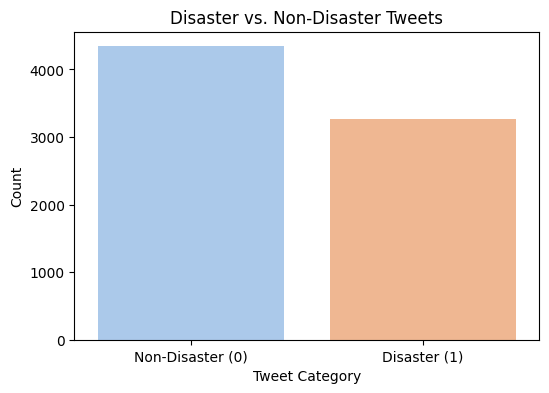

🔹 Non-Disaster Tweets: 4342
🔹 Disaster Tweets: 3271


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


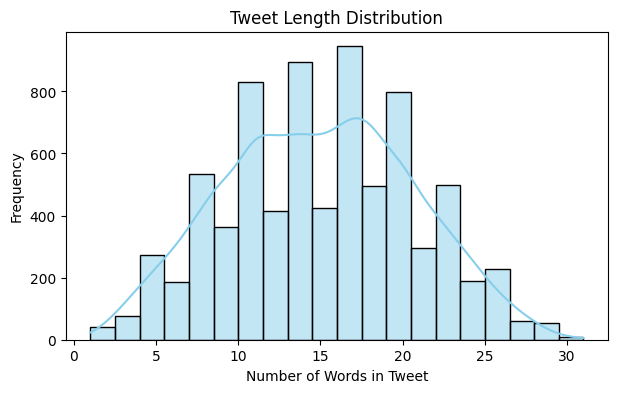

🔹 Average Tweet Length: 14.9


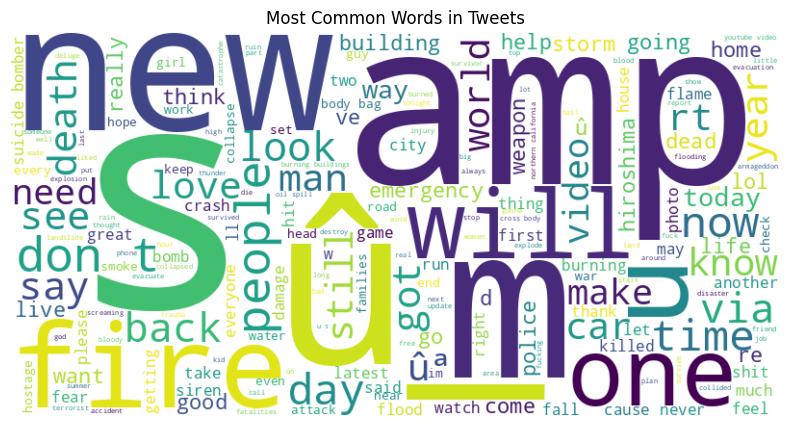

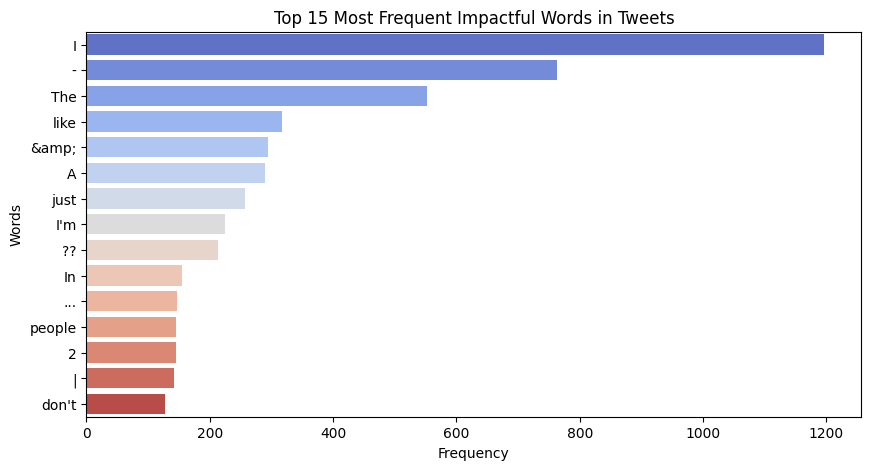

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


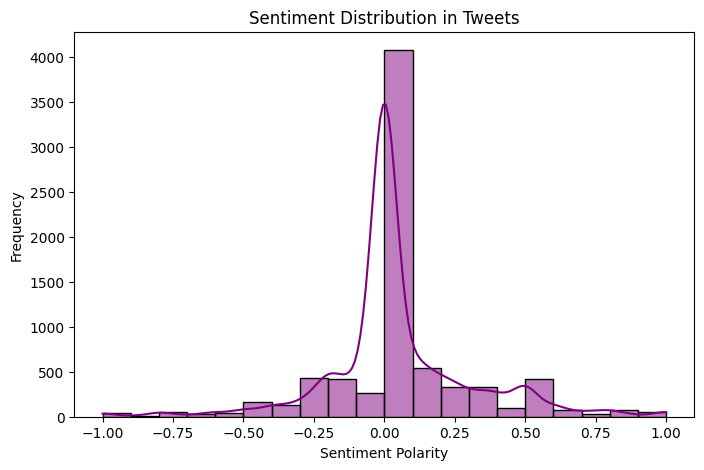

 Sentiment Polarity Range: -1.0 to 1.0


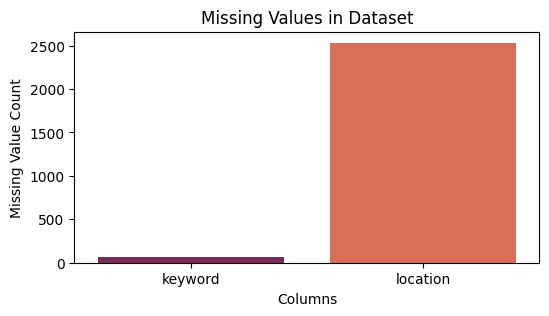

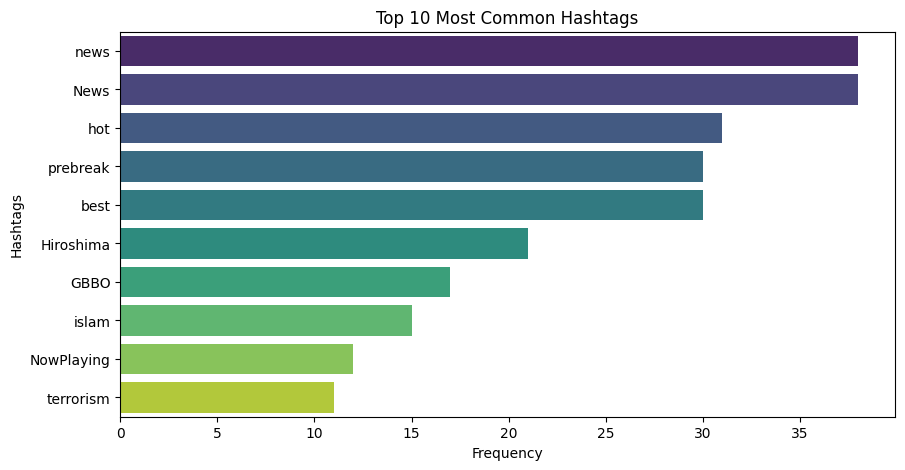

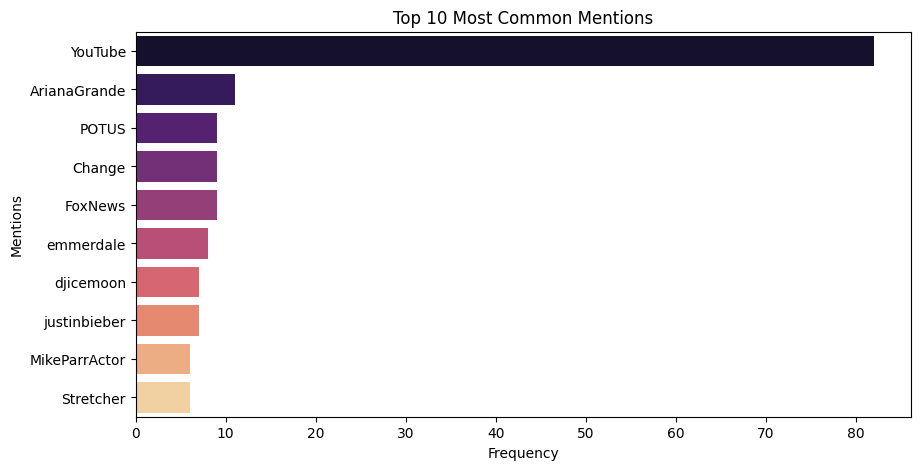

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob
import re


### **Check Dataset Distribution**
plt.figure(figsize=(6,4))
sns.countplot(x=df_train["target"], palette="pastel")
plt.xlabel("Tweet Category")
plt.ylabel("Count")
plt.title("Disaster vs. Non-Disaster Tweets")
plt.xticks(ticks=[0,1], labels=["Non-Disaster (0)", "Disaster (1)"])
plt.show()

print("🔹 Non-Disaster Tweets:", df_train["target"].value_counts()[0])
print("🔹 Disaster Tweets:", df_train["target"].value_counts()[1])

### **Word Count & Tweet Length Analysis**
df_train["tweet_length"] = df_train["text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(7,4))
sns.histplot(df_train["tweet_length"], bins=20, kde=True, color="skyblue")
plt.xlabel("Number of Words in Tweet")
plt.ylabel("Frequency")
plt.title("Tweet Length Distribution")
plt.show()

print("🔹 Average Tweet Length:", np.round(df_train['tweet_length'].mean(), 2))

### **Most Common Words (WordCloud & Bar Plot)**
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\@w+|\#','', text)  # Remove mentions & hashtags
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    return text.lower()

df_train["clean_text"] = df_train["text"].apply(preprocess_text)
all_words = " ".join(df_train["clean_text"])
word_freq = Counter(all_words.split())

# WordCloud
plt.figure(figsize=(10,5))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Tweets")
plt.show()

# Bar Plot of Most Common Words
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Extracting Most Frequent Words without Stopwords
all_words = " ".join(df_train["text"]).split()
filtered_words = [word for word in all_words if word not in ENGLISH_STOP_WORDS]
word_freq = Counter(filtered_words)

# Bar Plot of Most Common Impactful Words
common_words = pd.DataFrame(word_freq.most_common(15), columns=["Word", "Count"])
plt.figure(figsize=(10,5))
sns.barplot(y=common_words["Word"], x=common_words["Count"], palette="coolwarm")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 15 Most Frequent Impactful Words in Tweets")
plt.show()

### ** Sentiment Score Distribution**
df_train["sentiment"] = df_train["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(8,5))
sns.histplot(df_train["sentiment"], bins=20, kde=True, color="purple")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.title("Sentiment Distribution in Tweets")
plt.show()

print(" Sentiment Polarity Range:", df_train["sentiment"].min(), "to", df_train["sentiment"].max())

### ** Missing Values Analysis**
missing_values = df_train.isnull().sum()
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    plt.figure(figsize=(6, 3))
    sns.barplot(x=missing_values.index, y=missing_values.values, palette="rocket")
    plt.xlabel("Columns")
    plt.ylabel("Missing Value Count")
    plt.title("Missing Values in Dataset")
    plt.show()
else:
    print(" No Missing Values in Training Data.")

### ** Hashtag & Mention Analysis**
df_train["hashtags"] = df_train["text"].apply(lambda x: re.findall(r"#(\w+)", x))
df_train["mentions"] = df_train["text"].apply(lambda x: re.findall(r"@(\w+)", x))

# Flatten the lists
all_hashtags = [tag for sublist in df_train["hashtags"] for tag in sublist]
all_mentions = [mention for sublist in df_train["mentions"] for mention in sublist]

# Most common hashtags
common_hashtags = pd.DataFrame(Counter(all_hashtags).most_common(10), columns=["Hashtag", "Count"])
plt.figure(figsize=(10,5))
sns.barplot(y=common_hashtags["Hashtag"], x=common_hashtags["Count"], palette="viridis")
plt.xlabel("Frequency")
plt.ylabel("Hashtags")
plt.title("Top 10 Most Common Hashtags")
plt.show()

# Most common mentions
if all_mentions:
    common_mentions = pd.DataFrame(Counter(all_mentions).most_common(10), columns=["Mention", "Count"])
    plt.figure(figsize=(10,5))
    sns.barplot(y=common_mentions["Mention"], x=common_mentions["Count"], palette="magma")
    plt.xlabel("Frequency")
    plt.ylabel("Mentions")
    plt.title("Top 10 Most Common Mentions")
    plt.show()
else:
    print(" No mentions found in dataset.")


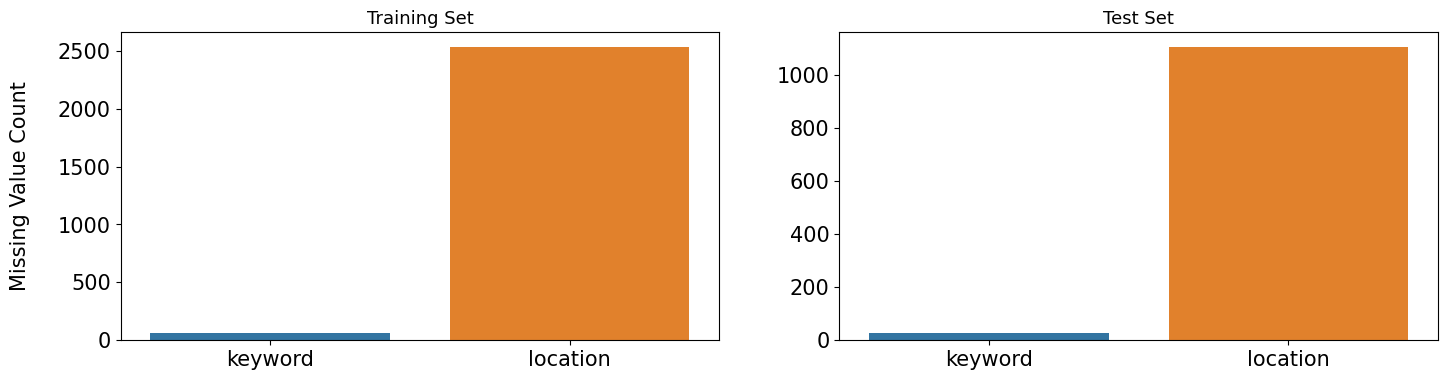

In [16]:

missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [17]:
import re
import emoji
import unicodedata
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

# Pre-compiled regex patterns for efficiency
URL_PATTERN = re.compile(r"http\S+|www\S+|https\S+")
MENTION_PATTERN = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#\w+")
SPECIAL_CHAR_PATTERN = re.compile(r"[^a-zA-Z0-9\s]")
stop_words = set(ENGLISH_STOP_WORDS)

# Text Preprocessing Function
def clean_text(text):
    text = text.lower()
    text = URL_PATTERN.sub("", text)  # Remove URLs
    text = MENTION_PATTERN.sub("", text)  # Remove mentions
    text = HASHTAG_PATTERN.sub("", text)  # Remove hashtags
    text = SPECIAL_CHAR_PATTERN.sub(" ", text)  # Remove special characters
    text = emoji.replace_emoji(text, replace="")  # Remove emojis
    text = " ".join([word for word in text.split() if word not in stop_words])  # Stopword removal
    return text

# Apply preprocessing (Vectorized)
df_train["text"] = df_train["text"].apply(clean_text)
df_test["text"] = df_test["text"].apply(clean_text)

# Feature Extraction
sia = SentimentIntensityAnalyzer()

def extract_features(df):
    df["tweet_length"] = df["text"].str.len()
    df["num_capitals"] = df["text"].str.count(r"[A-Z]")
    df["num_special_chars"] = df["text"].str.count(r"[!?@#]")
    df["num_digits"] = df["text"].str.count(r"\d")
    df["sentiment_score"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])  # Faster Sentiment Scoring
    return df

# Apply feature extraction
df_train = extract_features(df_train)
df_test = extract_features(df_test)

/usr/local/lib/python3.10/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [18]:
# Train-validation split
X = df_train["text"]
y = df_train["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test["text"]

# Load DistilBERT model
preset = "distil_bert_base_en_uncased"
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160, name="preprocessor_4_tweets")
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor=preprocessor, num_classes=2)
classifier.summary()


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 2553s 26s/step - accuracy: 0.7301 - loss: 0.5491 - val_accuracy: 0.8267 - val_loss: 0.4197
Epoch 2/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 2519s 26s/step - accuracy: 0.8397 - loss: 0.3845 - val_accuracy: 0.8240 - val_loss: 0.4129
96/96 ━━━━━━━━━━━━━━━━━━━━ 542s 6s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step


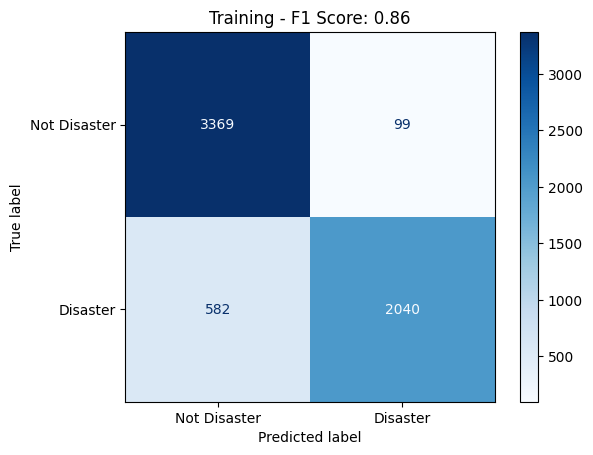

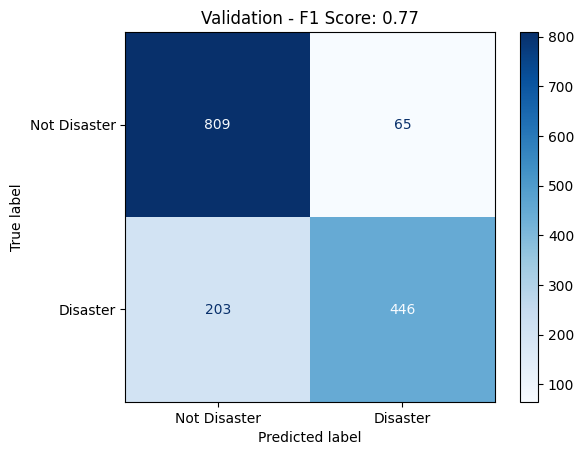

In [19]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import AdamW
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Enable Mixed Precision for Speed (FP16)
mixed_precision.set_global_policy("mixed_float16")

# Enable XLA Compilation (Just-in-Time Compilation)
tf.config.optimizer.set_jit(True)

# Enable TF32 for NVIDIA GPUs (If available, speeds up training)
tf.config.experimental.enable_tensor_float_32_execution(True)

# **Use Optimized AdamW Optimizer (Faster for Transformers)**
optimizer = AdamW(learning_rate=3e-5, weight_decay=1e-2)

# ** Compile Model with JIT Compilation**
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"],
    jit_compile=True  # Further Speeds Up Training
)

# ** Train the Model Efficiently**
history = classifier.fit(
    X_train, y_train,
    batch_size=64,  # Increase batch size (if GPU has enough memory)
    epochs=2,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)]
)

# ** Model Evaluation & Confusion Matrix**
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )
    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp + (fn+fp)/2)
    disp.ax_.set_title(f"{dataset} - F1 Score: {f1_score:.2f}")

# ** Predict & Evaluate**
y_pred_train = classifier.predict(X_train, batch_size=64)
displayConfusionMatrix(y_train, y_pred_train, "Training")

y_pred_val = classifier.predict(X_val, batch_size=64)
displayConfusionMatrix(y_val, y_pred_val, "Validation")


In [20]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [21]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)
sample_submission.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step
